In [ ]:
!gdown --id 1Rb-9DYp8hHO60Tk_-_kK1E7Axeaog4rA # dataset

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Rb-9DYp8hHO60Tk_-_kK1E7Axeaog4rA
To: /content/segthor png.7z
100% 771M/771M [00:03<00:00, 232MB/s]


In [ ]:
!gdown --id 1XA3RD_sKtcNitf-3SQ_a85_v9Q2_DU3r # resnet weights

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1XA3RD_sKtcNitf-3SQ_a85_v9Q2_DU3r
To: /content/resnet18_v2.pth
100% 44.8M/44.8M [00:02<00:00, 21.7MB/s]


In [ ]:
!7z x '/content/segthor png.7z' -o"/content/segthor"


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 771039890 bytes (736 MiB)

Extracting archive: /content/segthor png.7z
 11% 4096 Open              WARNING:
/content/segthor png.7z
Can not open the file as [7z] archive
The file is open as [zip] archive

--
Path = /content/segthor png.7z
Open WARNING: Can not open the file as [7z] archive
Type = zip
Physical Size = 771039890

  0%      0% 169 - segthor png/Patient_01_image_25.png                                                1% 380 - segthor png/Patient_01_image_44.png                                    

In [ ]:
!pip install -q segmentation-models-pytorch

     |████████████████████████████████| 88 kB 3.3 MB/s 
     |████████████████████████████████| 58 kB 6.0 MB/s 
     |████████████████████████████████| 376 kB 28.6 MB/s 


In [ ]:
!pip install -q torchmetrics

     |████████████████████████████████| 409 kB 4.1 MB/s 


In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.optim as optim
from torch.optim import lr_scheduler
from time import time
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from IPython.display import clear_output
import time
import pandas as pd

class CTA_Dataset(Dataset):
    def __init__(self, csv_root, png_root):
        self.csv = pd.read_csv(csv_root)
        self.root = png_root
   
    def __getitem__(self, idx):
        image = np.asarray(Image.open(os.path.join(self.root, self.csv.loc[idx, 'filename_image'])).convert('L'))
        mask = np.asarray(Image.open(os.path.join(self.root, self.csv.loc[idx, 'filename_label'])).convert('L'))
        resolution = (int(self.csv.loc[idx, 'resolution'].split(',')[0][1:]),
                      int(self.csv.loc[idx, 'resolution'].split(',')[1][1:-1]))
        filename = self.csv.loc[idx, 'filename_image']

        trans = transforms.Compose([transforms.ToTensor(),
                                    ])
        mask = trans(mask)
        image = trans(image)

        mask = TF.resize(mask, 224)
        image = TF.resize(image, 224)

        return {'image': image.float(),
                'mask': mask.float(),
                'resolution': torch.tensor(resolution),
                'filename': filename}

    def __len__(self):
        return self.csv.shape[0]

In [ ]:
dataset = CTA_Dataset('/content/segthor.csv', '/content/segthor/segthor png')

print('Размер датасета', len(dataset))

Размер датасета 17269


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:133: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


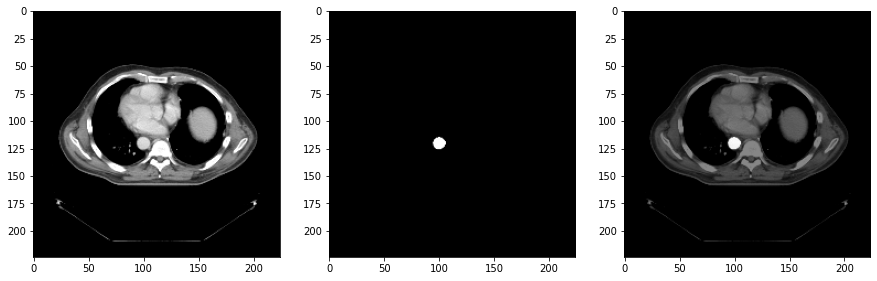

In [ ]:
data = dataset.__getitem__(800)
image = data['image']
mask = data['mask']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
ax1.imshow(image[0], cmap='gray')
ax2.imshow(mask[0], cmap='gray')
ax3.imshow(image[0] + mask[0], cmap='gray')
plt.show()

In [ ]:
train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size
torch.manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

data_loader_train = torch.utils.data.DataLoader(
 train_dataset, batch_size=32, shuffle=True)

data_loader_val = torch.utils.data.DataLoader(
 val_dataset, batch_size=64, shuffle=False)

In [ ]:
import segmentation_models_pytorch as smp

loss_fn = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
# metrics = smp.utils.metrics.IoU(threshold=0.5)

In [ ]:
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet.fc = nn.Linear(512, 1)
resnet.load_state_dict(torch.load('/content/resnet18_v2.pth'))

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
resnet.to(device)

for p in resnet.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
lr_scheduler_exp = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    return iou

In [ ]:
THRESHOLD = 0.01 # получен ранее (см. resnet)
device = 'cuda'
def train(cls_model, seg_model, opt, scheduler, loss_fn, epochs, data_tr, data_val, score=True):
    data = next(iter(data_val))
    X_val, Y_val = data['image'], data['mask']
    history_train_loss = []
    history_val_loss = []
    best_loss = np.inf
    best_metric = -1
    if score:
        history_metric = []

    cls_model.eval()
    sigmoid = nn.Sigmoid()
    start_time = time.time()
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        train_avg_loss, val_avg_loss = 0, 0
        seg_model.train() 
        for data in data_tr:
            X_batch = data['image'].cuda()
            Y_batch = data['mask'].cuda()

            # resnet classifier
            cls_pred = (sigmoid(cls_model(X_batch)) >= THRESHOLD) * 1
            cls_pred = cls_pred.squeeze(1)
            true_idxs = cls_pred.nonzero().squeeze(1).tolist()

            opt.zero_grad()
            
            output = seg_model(X_batch[true_idxs]) 
            Y_pred = torch.zeros((Y_batch.size(0), 2, Y_batch.size(2), Y_batch.size(3)), dtype=torch.float32).to(device)
            Y_pred[true_idxs] = output


            loss = loss_fn(output, Y_batch[true_idxs].long())
            loss.backward()  
            opt.step()

            train_avg_loss += loss.item() / len(data_tr) 

        scheduler.step()
        history_train_loss.append(train_avg_loss)

        seg_model.eval()  
        output = seg_model(X_val.to(device))
        Y_hat = output.cpu().detach()
        scores = 0
        with torch.no_grad():
            for data in data_val:
                X_batch = data['image'].to(device)
                Y_batch = data['mask'].to(device)


                cls_pred = (sigmoid(cls_model(X_batch)) >= THRESHOLD) * 1
                cls_pred = cls_pred.squeeze(1)
                true_idxs = cls_pred.nonzero().squeeze(1).tolist()

                output = seg_model(X_batch[true_idxs]) 
                Y_pred = torch.zeros((Y_batch.size(0), 2, Y_batch.size(2), Y_batch.size(3)), dtype=torch.float32).to(device)
                Y_pred[true_idxs] = output

                scores += iou_pytorch(Y_pred.argmax(1).long(), Y_batch.long()).mean().item()

                loss = loss_fn(output, Y_batch[true_idxs].long()) 

                val_avg_loss += loss.item() / len(data_val)

            history_val_loss.append(val_avg_loss)
            metric = scores / len(data_val)

            elapsed_time = time.time() - start_time
            loss_log = f'Train loss: {train_avg_loss:0.5f}, Elapsed_time: {elapsed_time:0.5f}'
            current_model_log = f'{"Current_metric":17s}: {metric:0.3f}, {"Current_loss":17s}: {val_avg_loss:0.2f}'

            if val_avg_loss < best_loss:
                best_loss = val_avg_loss
                torch.save(seg_model.state_dict(), f'{epoch+1}_epoch_best_loss{best_loss:.4f}.pth')

            if metric > best_metric:
                best_metric = metric
                torch.save(seg_model.state_dict(), f'{epoch+1}_epoch_best_metric{best_metric:.4f}.pth')

            if score:
                history_metric.append(metric)

        best_model_log = f'{"Best_metric":17s}: {best_metric:0.3f}, {"Best_loss":17s}: {best_loss:0.2f}'
        loss_model_log = f'{loss_log}\n{current_model_log}\n{best_model_log}'
        
        print(loss_model_log)
        dashed_line = '-' * 80
        print(dashed_line)
    if score:
        return history_train_loss, history_val_loss, metric
    else:  
        return history_train_loss, history_val_loss

In [ ]:
train_loss, val_loss, score = train(resnet, model, optimizer, lr_scheduler_exp, loss_fn, 20, data_loader_train, data_loader_val, score=True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:133: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


* Epoch 1/20
Train loss: 0.28511, Elapsed_time: 382.24016
Current_metric   : 0.897, Current_loss     : 0.08
Best_metric      : 0.897, Best_loss        : 0.08
--------------------------------------------------------------------------------
* Epoch 2/20
Train loss: 0.05624, Elapsed_time: 761.93520
Current_metric   : 0.917, Current_loss     : 0.05
Best_metric      : 0.917, Best_loss        : 0.05
--------------------------------------------------------------------------------
* Epoch 3/20
Train loss: 0.03913, Elapsed_time: 1139.73463
Current_metric   : 0.934, Current_loss     : 0.04
Best_metric      : 0.934, Best_loss        : 0.04
--------------------------------------------------------------------------------
* Epoch 4/20
Train loss: 0.03420, Elapsed_time: 1519.73111
Current_metric   : 0.939, Current_loss     : 0.03
Best_metric      : 0.939, Best_loss        : 0.03
--------------------------------------------------------------------------------
* Epoch 5/20
Train loss: 0.02932, Elapsed_

In [ ]:
from torchmetrics import JaccardIndex

jaccard = JaccardIndex(num_classes=2).cuda()

In [ ]:
scores = 0
val_avg_loss = 0
with torch.no_grad():
    for data in data_loader_train:
        X_batch = data['image'].to(device)
        Y_batch = data['mask'].to(device)


        cls_pred = (nn.Sigmoid()(resnet(X_batch)) >= THRESHOLD) * 1
        cls_pred = cls_pred.squeeze(1)
        true_idxs = cls_pred.nonzero().squeeze(1).tolist()

        output = model(X_batch[true_idxs]) 
        Y_pred = torch.zeros((Y_batch.size(0), 2, Y_batch.size(2), Y_batch.size(3)), dtype=torch.float32).to(device)
        Y_pred[true_idxs] = output

        scores += iou_pytorch(Y_pred.argmax(1).long(), Y_batch.long()).mean()

        loss = loss_fn(Y_pred, Y_batch.long()) 

        val_avg_loss += loss.item() / len(data_loader_val)

    metric = scores / len(data_loader_val)

In [ ]:
scores / len(data_loader_train)

tensor(0.9675, device='cuda:0')

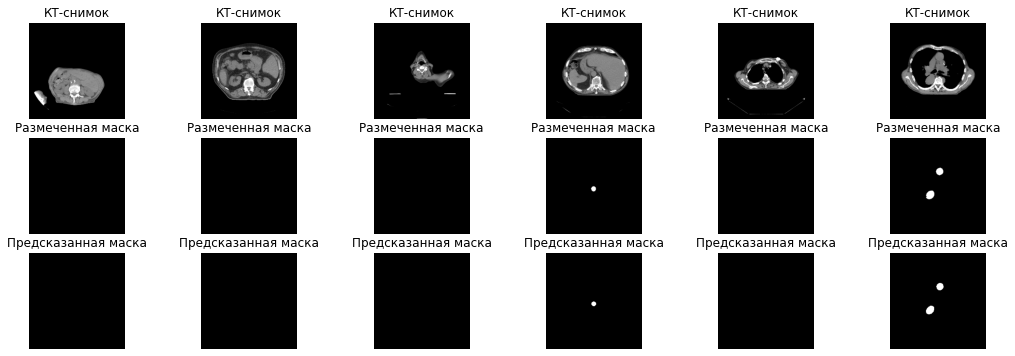

In [ ]:
# Visualize tools
clear_output(wait=True)
plt.figure(figsize=(18, 6))
for k in range(6):
    plt.subplot(3, 6, k+1)
    plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3)[:,:,0], cmap='gray')
    plt.title('КТ-снимок')
    plt.axis('off')

    plt.subplot(3, 6, k+7)
    plt.imshow(Y_val[k, 0].cpu().numpy(), cmap='gray')
    plt.title('Размеченная маска')
    plt.axis('off')

    plt.subplot(3, 6, k+13)
    plt.imshow(Y_hat[k].argmax(0).cpu().numpy(), cmap='gray')
    plt.title('Предсказанная маска')
    plt.axis('off')


plt.show()